# Plot

In [44]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

def plot_results(json_filepath, model_name, mode):
    """
    Loads model evaluation results from a JSON file and plots the results.
    - For 'perception' mode, it renders a bar plot as these have single values.
    - For other modes, it plots all conditions on a single line plot figure,
      rendering 'rule_only' and 'rule_only_query_desc' as horizontal dashed
      lines across all shot counts.
    """
    # --- 1. Load and Validate Data (Common to all modes) ---
    try:
        with open(json_filepath, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: JSON file not found at {json_filepath}")
        return
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {json_filepath}")
        return

    if model_name not in data:
        print(f"Error: Model '{model_name}' not found in the JSON data.")
        return

    print(f"Processing data for model '{model_name}' in '{mode}' mode...")
    datasets_for_model = data[model_name]

    # --- 2. Conditional Plotting: Bar Plot for 'perception', Line Plot for others ---

    if mode == "perception":
        # --- 2a. Perception Mode (Bar Plot) ---
        all_plot_data = []
        
        # Iterate through each dataset for the given model
        for dataset, ds_dict in datasets_for_model.items():
            # These conditions are expected to be at the dataset level, not per-shot
            conditions_to_check = ['perception_contain', 'perception_classification']
            
            for cond in conditions_to_check:
                if cond == "perception_classification":
                    # This is a nested dictionary of results
                    sub_dict = ds_dict.get(cond)
                    if isinstance(sub_dict, dict):
                        for sub_cond, score in sub_dict.items():
                            if score is not None:
                                all_plot_data.append({
                                    "dataset": dataset,
                                    "score": score,
                                    "condition": f"{cond} - {sub_cond}"
                                })
                else:
                    # This is a single score
                    score = ds_dict.get(cond)
                    if score is not None:
                        all_plot_data.append({
                            "dataset": dataset,
                            "score": score,
                            "condition": cond
                        })

        if not all_plot_data:
            print(f"No data found for 'perception' conditions for model '{model_name}'. Cannot generate plot.")
            return

        df_perception = pd.DataFrame(all_plot_data)

        # --- 3a. Styling and Plotting the Bar Plot ---
        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 7))
        
        ax = sns.barplot(
            data=df_perception,
            x="condition",
            y="score",
            hue="dataset",
            palette="viridis" # A colorblind-friendly palette suitable for bars
        )

        # Add score labels on top of each bar for clarity
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points',
                        fontsize=10)

        # --- 4a. Customize and Display the Bar Plot ---
        plt.title(f'Model: {model_name} - Perception Performance', fontsize=16)
        plt.xlabel('Perception Condition', fontsize=12)
        plt.ylabel('Score (%)', fontsize=12)
        plt.ylim(0, 100)
        
        # Rotate x-axis labels to prevent overlap
        plt.xticks(rotation=15, ha='right')
        plt.grid(True, axis='y', linewidth=0.6)
        
        # Adjust legend
        ax.legend(title="Dataset", loc="upper right")

        plt.tight_layout()
        plt.show()
        plt.close()

    else:
        # --- 2b. Other Modes (Line Plot) ---
        all_plot_data = []

        if mode == 'overall':
            per_shot_conditions = [
                'w_img', 'perception_contain', 'rule_only', 'rule_only_query_desc','demo_desc_query_desc', 'rule_demo'
            ]
        elif mode == "img_usage":
            per_shot_conditions = [
                'w_img', 'w_blank_img_all', 'w_blank_query_img', 'w_blank_demo_img'
            ]
        elif mode == "text_reasoning":
            per_shot_conditions = [
                'w_img', 'demo_desc_query_img', 'demo_desc_query_desc', 'demo_img_desc_query_img',
                'demo_img_desc_query_img_desc', 'demo_img_desc_query_img_desc_after_labels'
            ]
        else:
            raise ValueError(f"Invalid mode for line plot: {mode}")

        horizontal_line_conditions = ['rule_only', 'rule_only_query_desc']

        # Iterate datasets
        for dataset, ds_dict in datasets_for_model.items():
            shot_keys = sorted([int(k) for k in ds_dict.keys() if k.isdigit()])
            shot_strs = [str(k) for k in shot_keys]

            # Collect per-shot condition data
            for shot_str, shot_val in zip(shot_strs, shot_keys):
                shot_block = ds_dict.get(shot_str, {})
                if isinstance(shot_block, dict):
                    for cond in per_shot_conditions:
                        # Note: The original code had a special case for perception_classification
                        # which is now handled in the dedicated 'perception' mode.
                        # We assume it won't be a primary condition in other line plot modes.
                        score = shot_block.get(cond)
                        if score is not None:
                            all_plot_data.append({
                                "dataset": dataset,
                                "shots": shot_val,
                                "score": score,
                                "condition": cond
                            })

            # Collect dataset-level horizontal lines and expand across shots
            shots_for_lines = shot_keys if shot_keys else [0, 1, 2, 4, 5]
            for cond in horizontal_line_conditions:
                const_val = ds_dict.get(cond)
                if const_val is not None:
                    for shot_val in shots_for_lines:
                        all_plot_data.append({
                            "dataset": dataset,
                            "shots": shot_val,
                            "score": const_val,
                            "condition": cond
                        })

        if not all_plot_data:
            print(f"No data found for any condition for model '{model_name}'. Cannot generate plot.")
            return

        df_all = pd.DataFrame(all_plot_data)
        
        # --- 3b. Styling: colorblind-friendly, high-contrast palette ---
        sns.set_style("whitegrid")
        okabe_ito = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#F0E442", "#56B4E9", "#E69F00", "#000000"]
        unique_conditions = list(df_all['condition'].unique())

        def extend_palette(base_colors, needed):
            colors = []
            cycles = (needed + len(base_colors) - 1) // len(base_colors)
            for _ in range(cycles):
                for hex_col in base_colors:
                    colors.append(hex_col)
            return colors[:needed]

        color_list = extend_palette(okabe_ito, len(unique_conditions))
        color_map = {cond: color_list[i] for i, cond in enumerate(unique_conditions)}

        dashes_map = {cond: "" for cond in unique_conditions}
        if 'rule_only' in dashes_map:
            dashes_map['rule_only'] = (4, 2)
        if 'rule_only_query_desc' in dashes_map:
            dashes_map['rule_only_query_desc'] = (2, 2)

        # --- 4b. Plotting and Customizing the Line Plot ---
        plt.figure(figsize=(20, 5.5))
        ax = sns.lineplot(
            data=df_all,
            x="shots",
            y="score",
            hue="condition",
            style="condition",
            dashes=dashes_map,
            markers=True,
            linewidth=3,
            markersize=9,
            palette=color_map
        )

        plt.title(f'Model: {model_name} - Performance Comparison on Open-Ended Mini-ImageNet', fontsize=16)
        plt.xlabel('Number of Shots', fontsize=12)
        plt.ylabel('Score (%)', fontsize=12)
        plt.ylim(0, 100)

        all_shots_values = sorted(df_all['shots'].unique())
        plt.xticks(all_shots_values)
        plt.grid(True, linewidth=0.6)

        legend = ax.legend(
            title="Condition",
            bbox_to_anchor=(1.02, 1),
            loc="upper left",
            borderaxespad=0.0,
            fontsize='large',
            title_fontsize='x-large'
        )

        plt.tight_layout(rect=[0, 0, 0.8, 1])
        plt.show()
        plt.close()

# Table

In [35]:
import json
import os
import pandas as pd

def display_main_comparison_table(input_filename="data.json", model_name="qwen2.5-vl-3b", dataset_name="open_mi"):
    # --- 0. Helpers ---
    def sign_fmt(x):
        # Always show sign for positive or negative numbers, formatted to one decimal place.
        return f"{x:+.1f}"

    print(f"Attempting to read data from '{input_filename}'...")
    try:
        with open(input_filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: Input file not found at '{os.path.abspath(input_filename)}'.")
        return
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from '{input_filename}'. Details: {e}")
        return
    
    print("Successfully loaded and parsed JSON data.\n")

    if model_name not in data or dataset_name not in data[model_name]:
        print(f"Error: Required data for '{model_name}' -> '{dataset_name}' not found in the JSON file.")
        return
        
    ds_dict = data[model_name][dataset_name]
    shots = sorted([int(k) for k in ds_dict.keys() if str(k).isdigit()])

    rule_only = ds_dict.get('rule_only')
    rule_only_query_desc_val = ds_dict.get('rule_only_query_desc')

    # --- Changes are in the 'calculation' lambda functions below ---
    row_definitions = [
        {
            "label": "Ceiling: demo_img_desc_query_img_desc",
            "calculation": lambda scores, shot: f"{100:.1f}"
        },
        {
            "label": "w_img (Baseline)",
            "calculation": lambda scores, shot: f"{scores.get('w_img'):.1f}" if 'w_img' in scores else 'N/A'
        },

        {
            "label": "Induction gap: rule_only - w_img",
            "calculation": lambda scores, shot: (
                sign_fmt(rule_only - scores.get('w_img'))
                if rule_only is not None and 'w_img' in scores else 'N/A'
            )
        },
        {
            "label": "Demo image ignoring: w_blank_demo_img - w_img",
            "calculation": lambda scores, shot: (
                f"{scores.get('w_blank_demo_img'):.1f}({sign_fmt(scores.get('w_blank_demo_img') - scores.get('w_img'))})"
                if 'w_img' in scores and 'w_blank_demo_img' in scores else 'N/A'
            )
        },
        {
            "label": "Query image ignoring: w_blank_query_img - w_img",
            "calculation": lambda scores, shot: (
                f"{scores.get('w_blank_query_img'):.1f}({sign_fmt(scores.get('w_blank_query_img') - scores.get('w_img'))})"
                if 'w_img' in scores and 'w_blank_query_img' in scores else 'N/A'
            )
        },
        {
            "label": "All image ignoring: w_blank_img_all - w_img",
            "calculation": lambda scores, shot: (
                f"{scores.get('w_blank_img_all'):.1f}({sign_fmt(scores.get('w_blank_img_all') - scores.get('w_img'))})"
                if 'w_img' in scores and 'w_blank_img_all' in scores else 'N/A'
            )
        },
        # {
        #     "label": "Correct image usage gap"
        # },
        
        # {
        #     "label": "Text reasoning: demo_desc_query_img - w_img",
        #     "calculation": lambda scores, shot: (
        #         f"{scores.get('demo_desc_query_img'):.1f}({sign_fmt(scores.get('demo_desc_query_img') - scores.get('w_img'))})"
        #         if 'demo_desc_query_img' in scores and 'w_img' in scores else 'N/A'
        #     )
        # },

        {
            "label": "Text reasoning gap: rule_only_query_desc - demo_desc_query_desc ",
            "calculation": lambda scores, shot: (
                f"{scores.get('demo_desc_query_desc'):.1f}({sign_fmt(scores.get('demo_desc_query_desc') - scores.get('w_img'))})"
                if 'demo_desc_query_desc' in scores and 'w_img' in scores else 'N/A'
            )
        },
        # {
        #     "label": "Text reasoning: demo_img_desc_query_img - w_img",
        #     "calculation": lambda scores, shot: (
        #         f"{scores.get('demo_img_desc_query_img'):.1f}({sign_fmt(scores.get('demo_img_desc_query_img') - scores.get('w_img'))})"
        #         if 'demo_img_desc_query_img' in scores and 'w_img' in scores else 'N/A'
        #     )
        # },
        {
            "label": "Text aided multimodal reasoning: demo_img_desc_query_img_desc - w_img",
            "calculation": lambda scores, shot: (
                f"{scores.get('demo_img_desc_query_img_desc'):.1f}({sign_fmt(scores.get('demo_img_desc_query_img_desc') - scores.get('w_img'))})"
                if 'demo_img_desc_query_img_desc' in scores and 'w_img' in scores else 'N/A'
            )
        },
        
        
        {
            "label": "Vision Gap: demo_desc_query_desc - w_img",
            "calculation": lambda scores, shot: (
                sign_fmt(scores.get('demo_desc_query_desc') - scores.get('w_img'))
                if 'demo_desc_query_desc' in scores and 'w_img' in scores else 'N/A'
            )
        },
        
        {
            "label": "Execution gap: 100 - rule_only_query_desc",
            "calculation": lambda scores, shot: (
                sign_fmt(100 - rule_only_query_desc_val)
                if rule_only_query_desc_val is not None else 'N/A'
            )
        },
        {
            "label": "Multimodal execution gap: rule_only_query_desc - rule_only",
            "calculation": lambda scores, shot: f"{100 - rule_only_query_desc_val:.1f}( {(100 - rule_only)})" if rule_only is not None else 'N/A'
        }
    ]

    table_data = []
    index_labels = []
    for definition in row_definitions:
        index_labels.append(definition["label"])
        row_values = []
        for shot in shots:
            shot_scores = ds_dict.get(str(shot), {}) if str(shot) in ds_dict else {}
            # calculation returns a fully formatted string or 'N/A'
            value = definition["calculation"](shot_scores, shot)
            row_values.append(value)
        table_data.append(row_values)

    column_labels = [f"{s}-Shot" for s in shots]
    df = pd.DataFrame(table_data, index=index_labels, columns=column_labels)

    pd.set_option('display.width', 5000)
    pd.set_option('display.max_columns', 20)

    print(f"--- Performance Analysis: {model_name} | {dataset_name} ---")
    print(df)
    print("-" * (len(df.to_string().split('\n')[0])))



In [25]:
import json
import os
import pandas as pd

def display_rule_induction_comparison_table(input_filename="data.json", model_name="qwen2.5-vl-3b", dataset_name="open_mi"):
    """
    Reads model evaluation data from a JSON file, calculates performance differences,
    and prints a formatted table to the console using the pandas library.

    Args:
        input_filename (str): The path to the input JSON file.
    """
    # --- 1. Load Data from File ---
    print(f"Attempting to read data from '{input_filename}'...")
    try:
        with open(input_filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: Input file not found at '{os.path.abspath(input_filename)}'.")
        print("Please ensure the JSON file exists in the correct directory.")
        return
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from '{input_filename}'.")
        print(f"Please check the file for syntax errors. Details: {e}")
        return
    
    print("Successfully loaded and parsed JSON data.\n")

    # --- 2. Prepare Data and Extract Key Values ---
    if model_name not in data or dataset_name not in data[model_name]:
        print(f"Error: Required data for '{model_name}' -> '{dataset_name}' not found in the JSON file.")
        return
        
    ds_dict = data[model_name][dataset_name]

    # Identify shot keys (numeric strings) and sort
    shots = sorted([int(k) for k in ds_dict.keys() if str(k).isdigit()])

    # Extract dataset-level special values (not from shot '1')
    rule_only_val = ds_dict.get('rule_only')
    rule_only_query_desc_val = ds_dict.get('rule_only_query_desc')

    # --- 3. Define Row Calculations ---
    row_definitions = [
        {
            "label": "w_img (Baseline)",
            "calculation": lambda scores, shot: scores.get('w_img')
        },
        {
            "label": "Demo image usage: w_img - w_blank_demo_img",
            "calculation": lambda scores, shot: f"{scores.get('w_blank_demo_img'):.1f}( {(scores.get('w_img') - scores.get('w_blank_demo_img'))})" if 'w_img' in scores and 'w_blank_demo_img' in scores else 'N/A'
        },
        {
            "label": "Query image usage: w_img - w_blank_query_img",
            "calculation": lambda scores, shot: f"{scores.get('w_blank_query_img'):.1f}( {(scores.get('w_img') - scores.get('w_blank_query_img'))})" if 'w_img' in scores and 'w_blank_query_img' in scores else 'N/A'
        },
        {
            "label": "All image usage: w_img - w_blank_img_all",
            "calculation": lambda scores, shot: f"{scores.get('w_blank_img_all'):.1f}( {(scores.get('w_img') - scores.get('w_blank_img_all'))})" if 'w_img' in scores and 'w_blank_img_all' in scores else 'N/A'
        },
        
        {
            "label": " Text reasoning: demo_desc_query_desc - w_img",
            "calculation": lambda scores, shot: f"{scores.get('demo_desc_query_desc'):.1f}( {(scores.get('demo_desc_query_desc') - scores.get('w_img'))})" if 'demo_desc_query_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning + Multimodal application: demo_desc_query_img - w_img",
            "calculation": lambda scores, shot: f"{scores.get('demo_desc_query_img'):.1f}( {(scores.get('demo_desc_query_img') - scores.get('w_img'))})" if 'demo_desc_query_img' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: demo_img_desc_query_img - w_img",
            "calculation": lambda scores, shot: f"{scores.get('demo_img_desc_query_img'):.1f}( {(scores.get('demo_img_desc_query_img') - scores.get('w_img'))})" if 'demo_img_desc_query_img' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: demo_img_desc_query_img_desc - w_img",
            "calculation": lambda scores, shot: f"{scores.get('demo_img_desc_query_img_desc'):.1f}( {(scores.get('demo_img_desc_query_img_desc') - scores.get('w_img'))})" if 'demo_img_desc_query_img_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: rule_only_query_desc - w_img",
            "calculation": lambda scores, shot: f"{rule_only_query_desc_val:.1f}( {(rule_only_query_desc_val - scores.get('w_img'))})" if rule_only_query_desc_val is not None and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Vision Gap: demo_desc_query_desc - w_img",
            "calculation": lambda scores, shot: f"{scores.get('demo_desc_query_desc') - scores.get('w_img'):.1f}( {(scores.get('demo_desc_query_desc') - scores.get('w_img'))})" if 'demo_desc_query_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Induction gap: rule_only  - w_img",
            "calculation": lambda scores, shot: f"{rule_only_val:.1f}( {(rule_only_val - scores.get('w_img'))})" if rule_only_val is not None and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Execution gap: 100 - rule_only_query_desc",
            "calculation": lambda scores, shot: f"{100 - rule_only_query_desc_val:.1f}( {(100 - rule_only_query_desc_val)})" if rule_only_query_desc_val is not None else 'N/A'
        },
        {
            "label": "Multimodal execution gap: rule_only_query_desc - rule_only",
            "calculation": lambda scores, shot: f"{100 - rule_only_query_desc_val:.1f}( {(100 - rule_only_query_desc_val)})" if rule_only_query_desc_val is not None else 'N/A'
        }
    ]

    # --- 4. Process Data and Format for DataFrame ---
    table_data = []
    index_labels = []
    for definition in row_definitions:
        index_labels.append(definition["label"])
        row_values = []
        for shot in shots:
            shot_scores = ds_dict.get(str(shot), {}) if str(shot) in ds_dict else {}

            value = definition["calculation"](shot_scores, shot)

            # Format for display
            if isinstance(value, (int, float)):
                if " - " in definition["label"]:
                    formatted_value = f"+{value:.1f}" if value > 0 else f"{value:.1f}"
                else:
                    formatted_value = f"{value:.1f}"
            else:
                formatted_value = str(value)

            row_values.append(formatted_value)
        table_data.append(row_values)

    # --- 5. Create and Print Pandas DataFrame ---
    column_labels = [f"{s}-Shot" for s in shots]
    df = pd.DataFrame(table_data, index=index_labels, columns=column_labels)

    pd.set_option('display.width', 5000)
    pd.set_option('display.max_columns', 20)

    print(f"--- Performance Analysis: {model_name} | {dataset_name} ---")
    print(df)
    print("-" * (len(df.to_string().split('\n')[0])))

# Qwen2.5-vl


Processing data for model 'qwen2.5-vl-3b' in 'overall' mode...


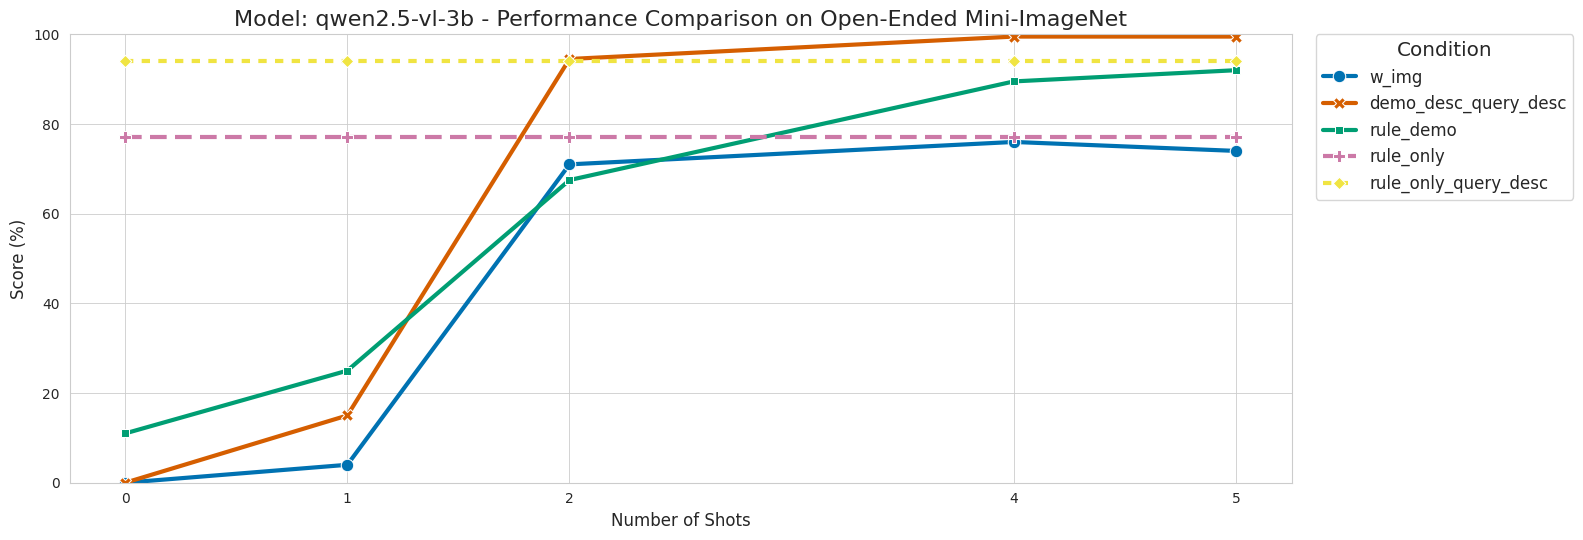

In [40]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

target_model = "qwen2.5-vl-3b"
json_file_path = f"/home/eml/yiran.huang/VL-ICL/results/{target_model}/compiled_evaluation_results_{target_model}_test.json"
plot_results(json_file_path, target_model,mode="overall")


Processing data for model 'qwen2.5-vl-3b' in 'perception' mode...


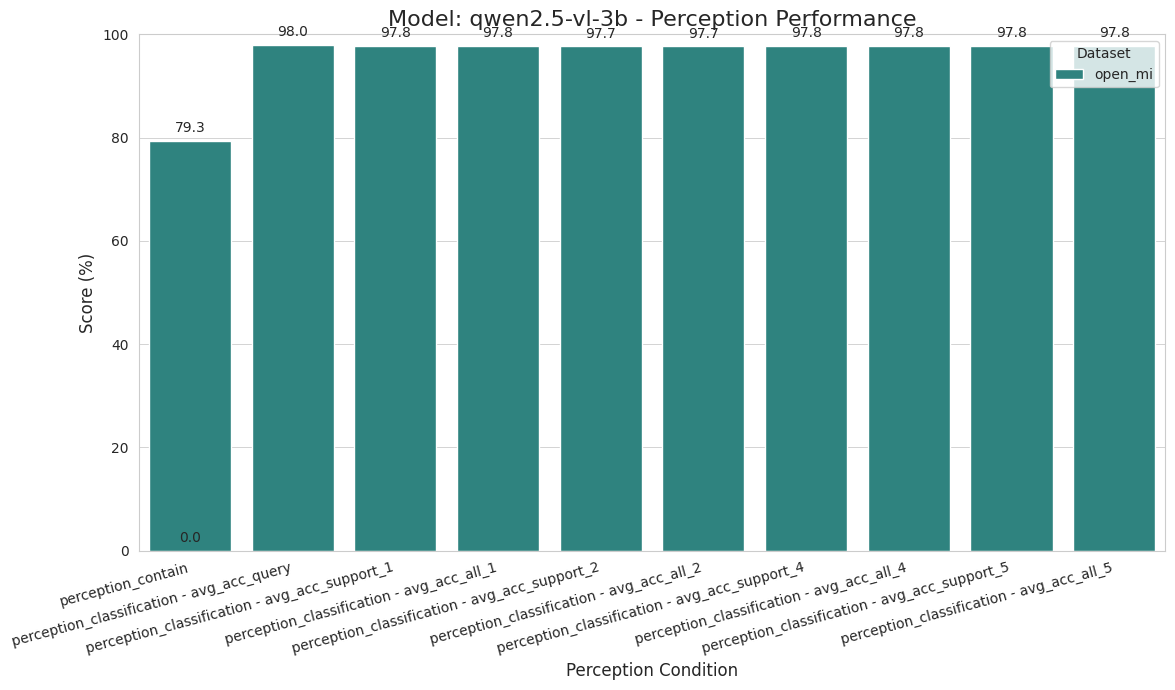

In [18]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd


target_model = "qwen2.5-vl-3b"
json_file_path = f"/home/eml/yiran.huang/VL-ICL/results/{target_model}/compiled_evaluation_results_{target_model}_test.json"
plot_results(json_file_path, target_model,mode="perception")


Processing data for model 'qwen2.5-vl-3b' in 'img_usage' mode...


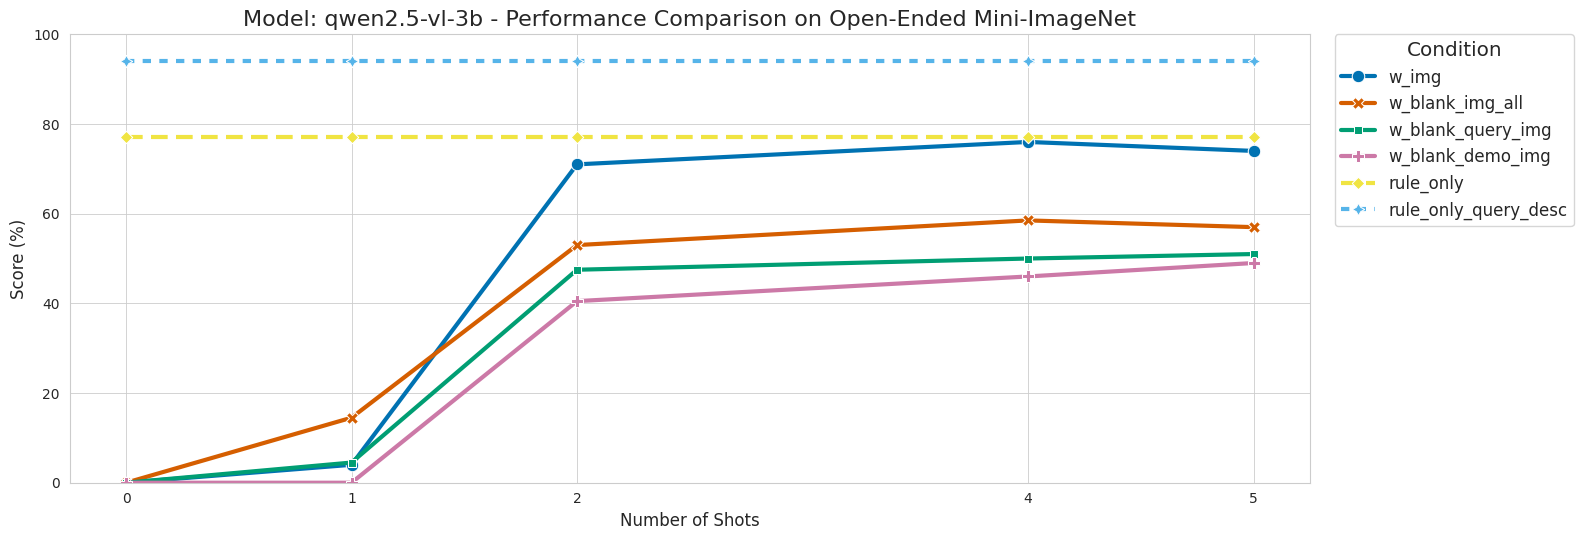

In [23]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd


target_model = "qwen2.5-vl-3b"
json_file_path = f"/home/eml/yiran.huang/VL-ICL/results/{target_model}/compiled_evaluation_results_{target_model}_test.json"
plot_results(json_file_path, target_model,mode="img_usage")


Processing data for model 'qwen2.5-vl-3b' in 'text_reasoning' mode...


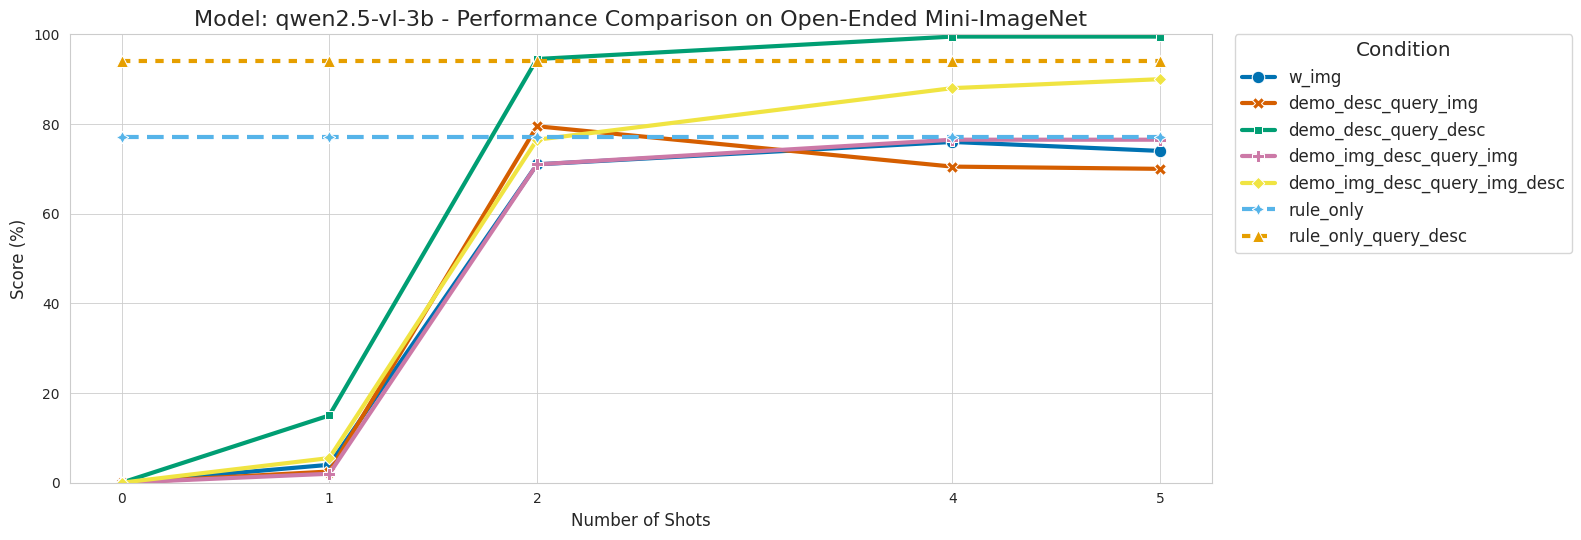

In [24]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd


target_model = "qwen2.5-vl-3b"
json_file_path = f"/home/eml/yiran.huang/VL-ICL/results/{target_model}/compiled_evaluation_results_{target_model}_test.json"
plot_results(json_file_path, target_model,mode="text_reasoning")


In [36]:
display_main_comparison_table(input_filename=json_file_path, model_name=target_model, dataset_name='open_mi')

Attempting to read data from '/home/eml/yiran.huang/VL-ICL/results/qwen2.5-vl-3b/compiled_evaluation_results_qwen2.5-vl-3b_test.json'...
Successfully loaded and parsed JSON data.

--- Performance Analysis: qwen2.5-vl-3b | open_mi ---
                                                        0-Shot       1-Shot       2-Shot       4-Shot       5-Shot
Ceiling: demo_img_desc_query_img_desc                    100.0        100.0        100.0        100.0        100.0
w_img (Baseline)                                           0.0          4.0         71.0         76.0         74.0
Induction gap: rule_only - w_img                         +77.0        +73.0         +6.0         +1.0         +3.0
Demo image ignoring: w_blank_demo_img - w_img        0.0(+0.0)    0.0(-4.0)  40.5(-30.5)  46.0(-30.0)  49.0(-25.0)
Query image ignoring: w_blank_query_img - w_img      0.0(+0.0)    4.5(+0.5)  47.5(-23.5)  50.0(-26.0)  51.0(-23.0)
All image ignoring: w_blank_img_all - w_img          0.0(+0.0)  14.5(+10.5) 

# Qwen2.5vl-7b

Processing data for model 'qwen2.5-vl-7b' in 'overall' mode...


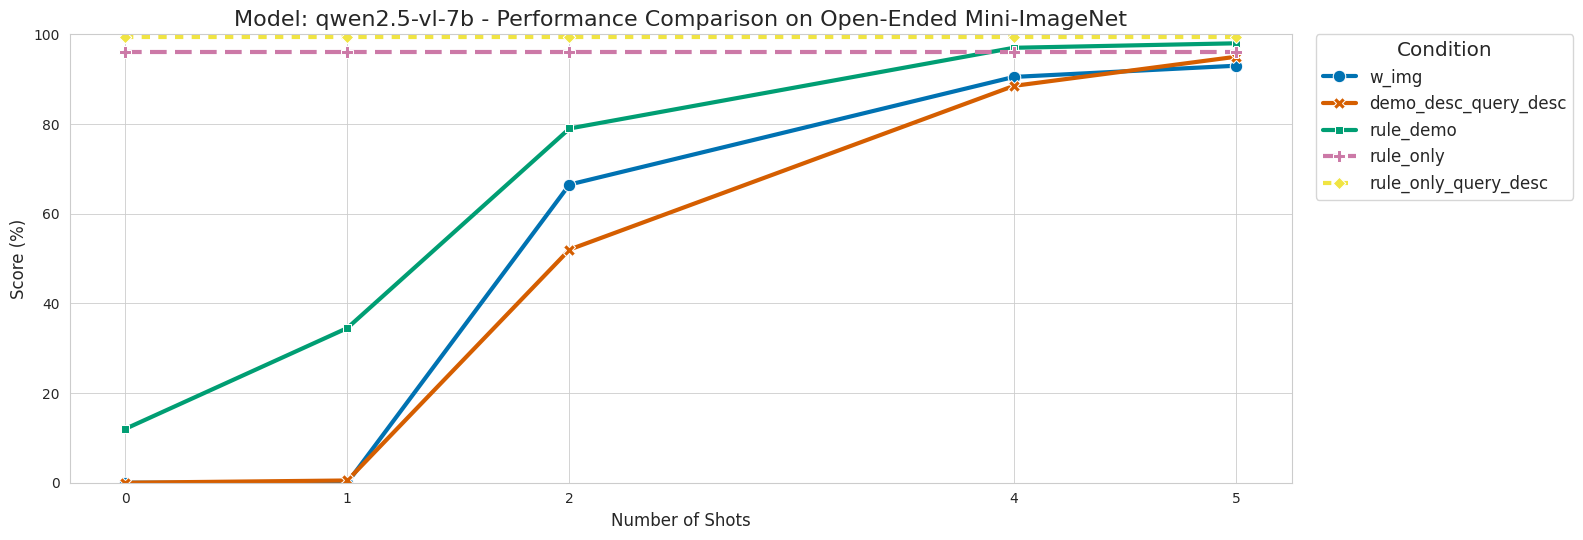

In [41]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# --- Configuration ---
# Define the model and the path to the results file.
target_model = "qwen2.5-vl-7b"
json_file_path = f"/home/eml/yiran.huang/VL-ICL/results/{target_model}/compiled_evaluation_results_{target_model}_test.json"
plot_results(json_file_path, target_model, mode="overall")

Processing data for model 'qwen2.5-vl-7b' in 'img_usage' mode...


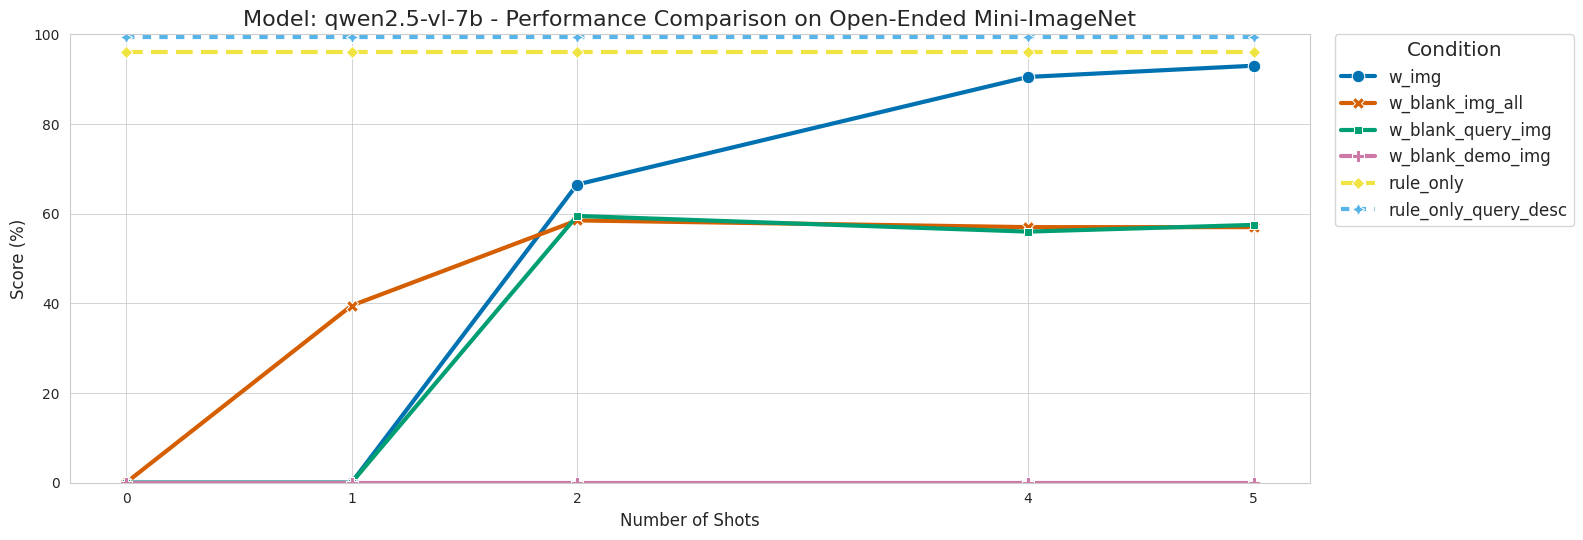

In [42]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# --- Configuration ---
# Define the model and the path to the results file.
target_model = "qwen2.5-vl-7b"
json_file_path = f"/home/eml/yiran.huang/VL-ICL/results/{target_model}/compiled_evaluation_results_{target_model}_test.json"
plot_results(json_file_path, target_model, mode="img_usage")

Processing data for model 'qwen2.5-vl-7b' in 'text_reasoning' mode...


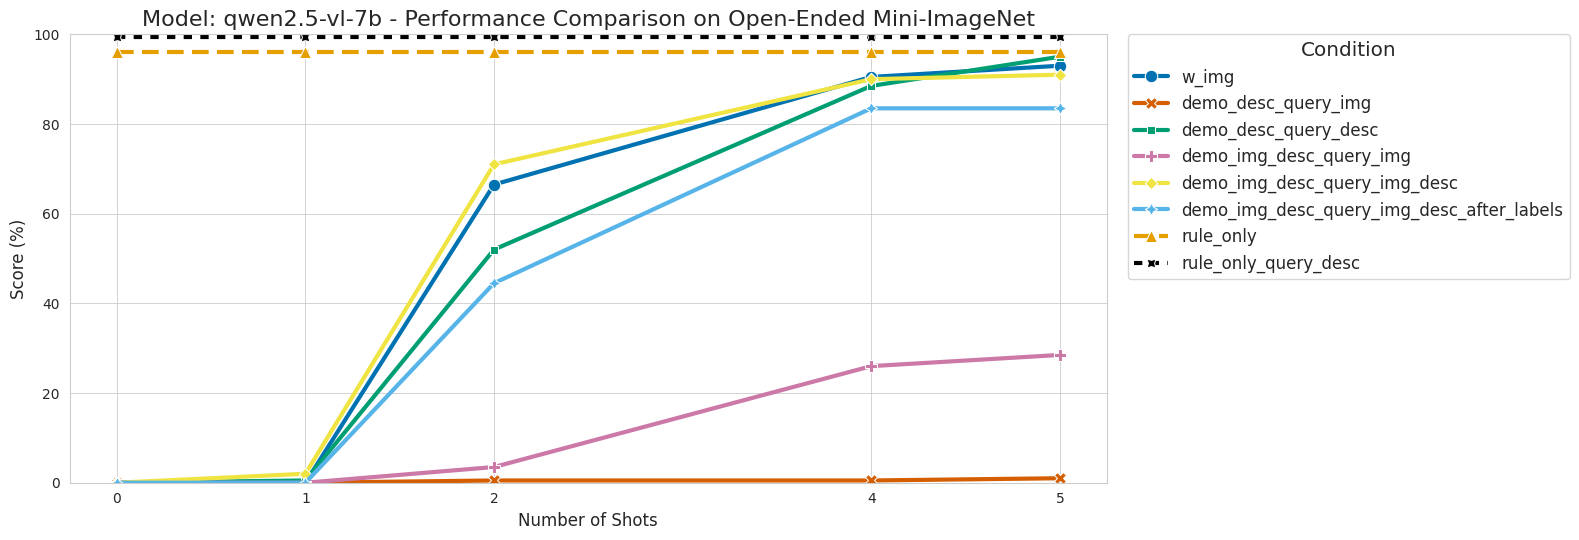

In [45]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# --- Configuration ---
# Define the model and the path to the results file.
target_model = "qwen2.5-vl-7b"
json_file_path = f"/home/eml/yiran.huang/VL-ICL/results/{target_model}/compiled_evaluation_results_{target_model}_test.json"
plot_results(json_file_path, target_model, mode="text_reasoning")

In [33]:
import json
import os
import pandas as pd

def display_comparison_table(input_filename="data.json",model_name="qwen2.5-vl-3b",dataset_name="open_mi"):
    """
    Reads model evaluation data from a JSON file, calculates performance differences,
    and prints a formatted table to the console using the pandas library.

    Args:
        input_filename (str): The path to the input JSON file.
    """
    # --- 1. Load Data from File ---
    print(f"Attempting to read data from '{input_filename}'...")
    try:
        with open(input_filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: Input file not found at '{os.path.abspath(input_filename)}'.")
        print("Please ensure the JSON file exists in the correct directory.")
        return
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from '{input_filename}'.")
        print(f"Please check the file for syntax errors. Details: {e}")
        return
    
    print("Successfully loaded and parsed JSON data.\n")

    # --- 2. Prepare Data and Extract Key Values ---
    
    if model_name not in data or dataset_name not in data[model_name]:
        print(f"Error: Required data for '{model_name}' -> '{dataset_name}' not found in the JSON file.")
        return
        
    all_shot_data = data[model_name][dataset_name]
    shots = sorted([int(s) for s in all_shot_data.keys()])

    # Extract special values (for "one vs. all" comparisons) from the 1-shot data
    one_shot_scores = all_shot_data.get('1', {})
    rule_only_val = one_shot_scores.get('rule_only')
    rule_only_query_desc_val = one_shot_scores.get('rule_only_query_desc')

    # --- 3. Define Row Calculations ---
    # This structure remains the same, defining the logic for each row.
    row_definitions = [
        {
            "label": "w_img (Baseline)",
            "calculation": lambda scores, shot: scores.get('w_img')
        },
        {
            "label": "Demo mage usage: w_img - w_blank_demo_img - the higher the better",
            "calculation": lambda scores, shot:  f"{(scores.get('w_blank_demo_img')):.1f}( {(scores.get('w_img')- scores.get('w_blank_demo_img'))})" if 'w_img' in scores and 'w_blank_demo_img' in scores else 'N/A'
        },
        {
            "label": "Query image usage: w_img - w_blank_query_img - the higher the better",
            "calculation": lambda scores, shot:  f"{scores.get('w_blank_query_img'):.1f}( {(scores.get('w_img')- scores.get('w_blank_query_img'))})" if 'w_img' in scores and 'w_blank_query_img' in scores else 'N/A'
        },
        {
            "label": "All image usage: w_img - w_blank_img_all - the higher the better",
            "calculation": lambda scores, shot:  f"{scores.get('w_blank_img_all'):.1f}( {(scores.get('w_img')- scores.get('w_blank_img_all'))})" if 'w_img' in scores and 'w_blank_img_all' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: demo_desc_query_img - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_desc_query_img'):.1f}( {(scores.get('demo_desc_query_img') - scores.get('w_img'))})" if 'demo_desc_query_img' in scores and 'w_img' in scores else 'N/A'
        },
         {
            "label": "Text reasoning: demo_desc_query_desc - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_desc_query_desc'):.1f}( {(scores.get('demo_desc_query_desc') - scores.get('w_img'))})" if 'demo_desc_query_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: demo_img_desc_query_img - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_img_desc_query_img'):.1f}( {(scores.get('demo_img_desc_query_img') - scores.get('w_img'))})" if 'demo_img_desc_query_img' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: demo_img_desc_query_img_desc - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_img_desc_query_img_desc'):.1f}( {(scores.get('demo_img_desc_query_img_desc') - scores.get('w_img'))})" if 'demo_img_desc_query_img_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: rule_only_query_desc - w_img",
            "calculation": lambda scores, shot:  f"{rule_only_query_desc_val:.1f}( {(rule_only_query_desc_val - scores.get('w_img'))})" if rule_only_query_desc_val is not None and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Vision Gap: demo_desc_query_desc - w_img",
            "calculation": lambda scores, shot: f"{scores.get('demo_desc_query_desc') - scores.get('w_img'):.1f}( {(scores.get('demo_desc_query_desc') - scores.get('w_img'))})" if 'demo_desc_query_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Induction gap: rule_only  - w_img",
            "calculation": lambda scores, shot: f"{rule_only_val:.1f}( {(rule_only_val- scores.get('w_img'))})" if rule_only_val is not None and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Execution gap: 100 - rule_only_query_desc",
            "calculation": lambda scores, shot: f"{100 - rule_only_query_desc_val:.1f}( {(100 - rule_only_query_desc_val)})" if rule_only_query_desc_val is not None else 'N/A'
        }
    ]

    # --- 4. Process Data and Format for DataFrame ---
    table_data = []
    index_labels = []
    for definition in row_definitions:
        index_labels.append(definition["label"])
        row_values = []
        for shot in shots:
            shot_scores = all_shot_data.get(str(shot), {})
            value = definition["calculation"](shot_scores, shot)
            
            # Format the value into a string for display purposes
            if isinstance(value, (int, float)):
                # For difference rows, add a '+' for positive values
                if " - " in definition["label"]:
                    if value > 0:
                        formatted_value = f"+{value:.1f}"
                    else:
                        formatted_value = f"{value:.1f}"
                # For baseline rows, just format the number
                else:
                    formatted_value = f"{value:.1f}"
            else:
                # Handle non-numeric values like 'N/A'
                formatted_value = str(value)
            
            row_values.append(formatted_value)
        table_data.append(row_values)

    # --- 5. Create and Print Pandas DataFrame ---
    column_labels = [f"{s}-Shot" for s in shots]
    
    # Create the DataFrame
    df = pd.DataFrame(table_data, index=index_labels, columns=column_labels)
    
    # Set display options to show all columns without truncation
    pd.set_option('display.width', 5000)
    pd.set_option('display.max_columns', 20)

    # Print a title and the DataFrame
    print(f"--- Performance Analysis: {model_name} | {dataset_name} ---")
    print(df)
    print("-" * (len(df.to_string().split('\n')[0]))) # Print a separator line



display_comparison_table(input_filename=json_file_path, model_name=target_model, dataset_name='open_mi')

Attempting to read data from '/home/eml/yiran.huang/VL-ICL/results/qwen2.5-vl-7b/compiled_evaluation_results_qwen2.5-vl-7b.json'...
Successfully loaded and parsed JSON data.

--- Performance Analysis: qwen2.5-vl-7b | open_mi ---
                                                         0-Shot        1-Shot        2-Shot       4-Shot       5-Shot
w_img (Baseline)                                            0.0           0.0          19.5         33.0         39.0
Demo mage usage: w_img - w_blank_demo_img - the...    0.0( 0.0)     0.0( 0.0)    1.5( 18.0)   2.0( 31.0)   2.0( 37.0)
Query image usage: w_img - w_blank_query_img - ...    0.0( 0.0)    1.5( -1.5)   20.0( -0.5)   25.0( 8.0)  28.5( 10.5)
All image usage: w_img - w_blank_img_all - the ...    0.0( 0.0)  38.0( -38.0)  41.0( -21.5)  37.5( -4.5)   39.0( 0.0)
Text reasoning: demo_desc_query_img - w_img           0.0( 0.0)     0.0( 0.0)   0.0( -19.5)  0.0( -33.0)  0.0( -39.0)
Text reasoning: demo_desc_query_desc - w_img          0.0( 0.0)